# Grad-CAM
TensorFlow 2.X implementation of [Grad-CAM](https://arxiv.org/pdf/1610.02391.pdf), an approach for model explainability which produces a heatmap of which regions of an image contributed strongly towards the final prediction.

In [1]:
%matplotlib inline

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import (
    ResNet50,
    preprocess_input,
    decode_predictions,
)
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K


The Grad-CAM output is an activation map which localises the detected objected to a region in the image. It is of width $u$ and height $v$, for the class $c$.
$$
L^{c}_{\textrm{Grad-CAM}} \in \mathbb{R}^{u \times v}
$$

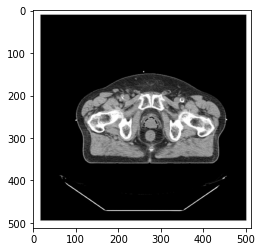

In [3]:
image = np.array(load_img("greyscale2.jpg", target_size=(512, 512, 3)))
plt.imshow(image)

In [6]:
# model = ResNet50()
smooth = 1.
def dice_coef(y_true, y_pred, const=K.epsilon()):
    '''
    Sørensen–Dice coefficient for 2-d samples.
    
    Input
    ----------
        y_true, y_pred: predicted outputs and targets.
        const: a constant that smooths the loss gradient and reduces numerical instabilities.
        
    '''
    
    # flatten 2-d tensors
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])
    
    # get true pos (TP), false neg (FN), false pos (FP).
    true_pos  = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos) * y_pred_pos)
    
    # 2TP/(2TP+FP+FN) == 2TP/()
    coef_val = (2.0 * true_pos + const)/(2.0 * true_pos + false_pos + false_neg)
    
    return coef_val



def dice(y_true, y_pred, const=K.epsilon()):

    # tf tensor casting
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    # <--- squeeze-out length-1 dimensions.
    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)

    loss_val = 1 - dice_coef(y_true, y_pred, const=const)

    return loss_val
# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# def dice_loss(y_true, y_pred):
#   y_true = tf.cast(y_true, tf.float32)
#   y_pred = tf.math.softmax(y_pred)
#   numerator = 2 * tf.reduce_sum(y_true * y_pred)
#   denominator = tf.reduce_sum(y_true + y_pred)

#   return 1 - numerator / denominator



path_to_model = '/Users/salvatoreesposito/Desktop/Attention_Unet'
model = tf.keras.models.load_model(path_to_model, custom_objects={'dice':dice, "dice_coef":dice_coef})

We get the output of the last convolution layer. We then create a model that goes up to only that layer.

In [7]:
last_conv_layer = model.get_layer("attunet_up3_att_psi_f")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

We create a model which then takes the output of the model above, and uses the remaining layers to get the final predictions.

In [11]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
# for layer_name in ["attunet_up3_att_sigmoid ", "predictions"]:
#     x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

First, we get the output from the model up till the last convolution layer.
We ask `tf` to watch this tensor output, as we want to calculate the gradients of the predictions of our target class wrt to the output of this model (last convolution layer model).

In [12]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

ValueError: Input 0 of layer attunet_down0_0 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (1, 512, 512, 3)

The partial derivative / gradient of the model output (logits / prior to softmax), $y^{c}$, with respect to the feature map (filter) activations of a specified convolution layer (the last convolution layer in this case) is:
$$
\frac{\partial y^{c}}{\partial A^{k}_{ij}}
$$

In [60]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

The gradients have a shape of `(u,v,Z)`, where `(u,v)` comes from the shape of the 2D convolution filter (i.e. width and height), and `Z` is the number of filters. The next step averages each of the filters to a single value, so that the final shape is `Z` or the number of filters. This is equivalent to the global average pooling 2D layer.

$$
\alpha_{k}^{c}=\frac{1}{Z}\sum_{i}\sum_{j}\frac{\partial y^{c}}{\partial A^{k}_{ij}}
$$

Each one of these gradients represents the connection from one of the pixels in the 2D array to the neuron / output representing the target class.

In [61]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

This is what the next layer in the model does which is a global average pooling 2D layer, which  averages and flattens the $z$ number of filters of $u \times v$ shape to single numbers (exactly what we did in previous step). This is necessary to create a connection to the fully connected (Dense) layers for the final prediction outputs.

The next step is to multiply the gradients (corresponding to the importance of the given feature map / filter) with the actual feature map (filter) it represents.

$$
ReLU\bigg(\sum_{k} a^{c}_{k}A^{k}\bigg)
$$

In [62]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [63]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (224, 224))

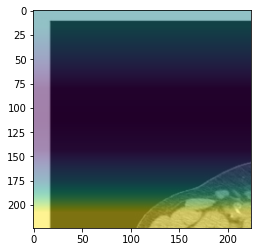

In [64]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5)

# Counterfactual explanation

By negating the value of $\frac{\partial y^{c}}{\partial A^{k}}$, we can produce a map of regions that would lower the network's confidence in its prediction. This is useful when two competing objects are present in the image. We can produce a "counterfactual" image with these regions masked out, which should give a higher confidence in the original prediction.

In [16]:
multiobject_image = np.array(
    load_img("greyscale2.jpg", target_size=(224, 224, 3))
)

In [17]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(multiobject_image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [18]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

The negative of the gradients is taken, to target the regions that do not contribute towards strengthen the network's predictions.

In [19]:
pooled_grads = tf.reduce_mean(-1 * grads, axis=(0, 1, 2))

In [20]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [21]:
# Average over all the filters to get a single 2D array
ctfcl_gradcam = np.mean(last_conv_layer_output, axis=-1)
# Normalise the values
ctfcl_gradcam = np.clip(ctfcl_gradcam, 0, np.max(ctfcl_gradcam)) / np.max(ctfcl_gradcam)
ctfcl_gradcam = cv2.resize(ctfcl_gradcam, (224, 224))

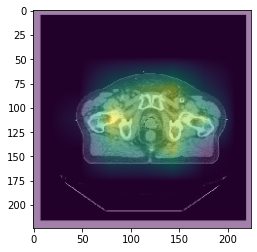

In [22]:
plt.imshow(multiobject_image)
plt.imshow(ctfcl_gradcam, alpha=0.5)

We can mask out the region identified by the counterfactual map, and re-run the predictions, where we should see a higher confidence in the outputs.

In [23]:
mask = cv2.resize(ctfcl_gradcam, (224, 224))
mask[mask > 0.1] = 255
mask[mask != 255] = 0
mask = mask.astype(bool)

In [24]:
ctfctl_image = multiobject_image.copy()
ctfctl_image[mask] = (0, 0, 0)

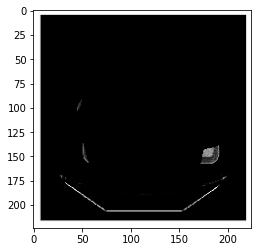

In [25]:
plt.imshow(ctfctl_image)

In [26]:
decode_predictions(model.predict(image[np.newaxis, ...]))

[[('n06359193', 'web_site', 0.6504333),
  ('n01930112', 'nematode', 0.06367682),
  ('n04209133', 'shower_cap', 0.026816905),
  ('n04553703', 'washbasin', 0.021806179),
  ('n01910747', 'jellyfish', 0.02148062)]]

In [27]:
decode_predictions(model.predict(ctfctl_image[np.newaxis, ...]))

[[('n06359193', 'web_site', 0.589295),
  ('n01930112', 'nematode', 0.08457268),
  ('n02916936', 'bulletproof_vest', 0.029506946),
  ('n04141076', 'sax', 0.023888104),
  ('n02667093', 'abaya', 0.011762567)]]

---

# Guided Grad-CAM

The Grad-CAM output can be improved further by combining with guided backpropagation, which zeroes elements in the gradients which act negatively towards the decision. Implementation from Raphael Meudec / [Sicara](https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow), [GitHub Gist](https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54).

This output, however, is still a low resolution heatmap, and not quite as described in the original paper. The original paper

In [28]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [29]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
last_conv_layer_output = last_conv_layer_output[0]

Guided backpropagation implementation:

In [30]:
guided_grads = (
    tf.cast(last_conv_layer_output > 0, "float32")
    * tf.cast(grads > 0, "float32")
    * grads
)

In [31]:
pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)

In [32]:
for i, w in enumerate(pooled_guided_grads):
    guided_gradcam += w * last_conv_layer_output[:, :, i]

In [33]:
guided_gradcam = cv2.resize(guided_gradcam.numpy(), (224, 224))

In [34]:
guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
    guided_gradcam.max() - guided_gradcam.min()
)

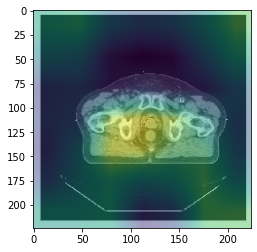

In [35]:
plt.imshow(image)
plt.imshow(guided_gradcam, alpha=0.5)

---

# Guided Grad-CAM (high resolution maps)
This approach reflects the paper's description better by first using the guided backpropagation approach to produce a high resolution map that is of the same resolution of the input image, which is then masked using the Grad-CAM heatmap to focus only on details that led to the prediction outcome. Based on the implementation on GitHub by [jacobgil](https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py).

In [36]:
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

In [38]:
class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads

In [39]:
gb = GuidedBackprop(model, "conv5_block3_out")

In [40]:
saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()
saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)

In [41]:
saliency_map -= saliency_map.mean()
saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
saliency_map *= 0.25
saliency_map += 0.5
saliency_map = np.clip(saliency_map, 0, 1)
saliency_map *= (2 ** 8) - 1
saliency_map = saliency_map.astype(np.uint8)

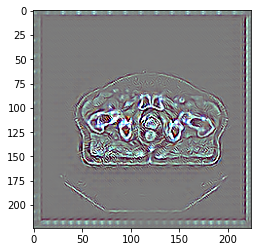

In [42]:
plt.imshow(saliency_map)